In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train / 255
x_test = x_test / 255

# (N, 28, 28) -> (N, 28, 28, 1)
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [4]:
def build_network():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Lambda(lambda x: K.l2_normalize(x, axis=1))
    ])

In [5]:
def euclidean_dist(a, b):
    sum_square = K.sum(K.square(a - b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [6]:
net = build_network()

img_a = tf.keras.Input(shape=(28, 28, 1))
img_b = tf.keras.Input(shape=(28, 28, 1))

embedding_a = net(img_a)
embedding_b = net(img_b)

distance = euclidean_dist(embedding_a, embedding_b)

siamese_model = tf.keras.Model([img_a, img_b], distance)

In [7]:
def contrastive_loss(y, dist):
    """
    y = 0 -> mesma classe
    y = 1 -> classes diferentes
    """
    margin = 1
    square_pred = K.square(dist)
    margin_square = K.square(K.maximum(margin - dist, 0))
    
    return K.mean((1-y) * square_pred + y * margin_square)

In [8]:
siamese_model.compile(loss=contrastive_loss)

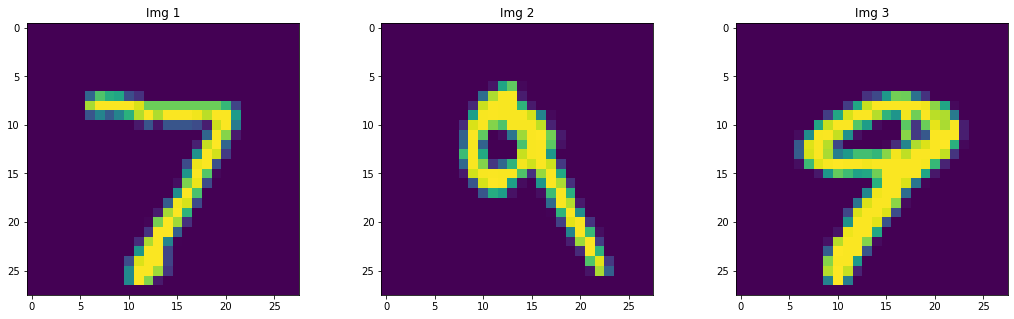

In [9]:
# Vamos ver a distancia entre os pares antes de treinar o modelo

idx_img_1 = 0
idx_img_2 = 7
idx_img_3 = 9

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.imshow(np.squeeze(x_test[idx_img_1]))
plt.title('Img 1')

plt.subplot(132)
plt.imshow(np.squeeze(x_test[idx_img_2]))
plt.title('Img 2')

plt.subplot(133)
plt.imshow(np.squeeze(x_test[idx_img_3]))
plt.title('Img 3');

In [10]:
inputs = x_test[[idx_img_1, idx_img_2, idx_img_3]]
embeddings = net.predict(inputs)

dist_1_2 = np.sqrt(np.sum(np.square(embeddings[0] - embeddings[1])))
dist_1_3 = np.sqrt(np.sum(np.square(embeddings[0] - embeddings[2])))
dist_2_3 = np.sqrt(np.sum(np.square(embeddings[1] - embeddings[2])))

print(f'Dist 7 and 9: {dist_1_2}')
print(f'Dist 7 and 9: {dist_1_3}')
print(f'Dist 9 and 9: {dist_2_3}')

Dist 7 and 9: 0.7633450627326965
Dist 7 and 9: 0.6070169806480408
Dist 9 and 9: 0.6867202520370483


In [11]:
def build_pairs_dataset(x, y):
    ex_per_class = [np.sum(y_train == cls) for cls in range(10)]
    n = min(ex_per_class)

    pairs = []
    labels = []

    for cls in np.arange(10):
        idx_cls = np.where(y == cls)[0]
        idx_not_cls = np.where(y != cls)[0]
        for i in range(n):
            # Positive pair
            idx1, idx2 = np.random.choice(idx_cls, size=2, replace=False)
            pairs.append([x[idx1], x[idx2]])
            labels.append(0)

            # Negative pair
            idx1 = np.random.choice(idx_cls, size=1, replace=False)[0]
            idx2 = np.random.choice(idx_not_cls, size=1, replace=False)[0]
            pairs.append([x[idx1], x[idx2]])
            labels.append(1)

    pairs = np.array(pairs)
    labels = np.array(labels)

    return pairs, labels

In [12]:
%%time
pairs, labels = build_pairs_dataset(x_train, y_train)

CPU times: user 1min 3s, sys: 570 ms, total: 1min 4s
Wall time: 1min 4s


In [13]:
inputs = [pairs[:, 0, ...], pairs[:, 1, ...]]
labels = labels.astype(np.float32)

history = siamese_model.fit(inputs, labels, batch_size=128, epochs=15)

Epoch 1/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0435
Epoch 2/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0120
Epoch 3/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0084
Epoch 4/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0066
Epoch 5/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0054
Epoch 6/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0047
Epoch 7/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0039
Epoch 8/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0036
Epoch 9/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0035
Epoch 10/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 11/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 12/15
848/848 [==============================] - 5s 6ms/step - loss: 0.0027
Epoch 13/15
848/848 [====

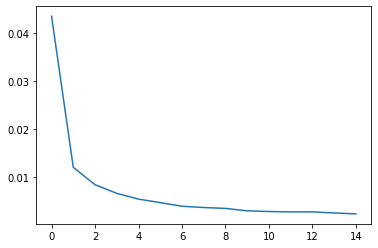

In [14]:
plt.plot(history.history["loss"]);

In [15]:
# Vamos olhar como ficaram aquelas distancias que vimos antes
inputs = x_test[[idx_img_1, idx_img_2, idx_img_3]]
embeddings = net.predict(inputs)

dist_1_2 = np.sqrt(np.sum(np.square(embeddings[0] - embeddings[1])))
dist_1_3 = np.sqrt(np.sum(np.square(embeddings[0] - embeddings[2])))
dist_2_3 = np.sqrt(np.sum(np.square(embeddings[1] - embeddings[2])))

print(f'Dist 7 and 9: {dist_1_2}')
print(f'Dist 7 and 9: {dist_1_3}')
print(f'Dist 9 and 9: {dist_2_3}')

Dist 7 and 9: 1.0004618167877197
Dist 7 and 9: 1.0004571676254272
Dist 9 and 9: 0.002561174100264907


Funcionou muito bem! Podemos ver que as imagens do mesmo digito ficaram próximas.

Alguns materiais para se aprovundar nos assuntos da aula:
- https://sthalles.github.io/simple-self-supervised-learning/
- https://gombru.github.io/2019/04/03/ranking_loss/
- https://arxiv.org/pdf/2001.07685.pdf
- https://arxiv.org/pdf/1503.02531.pdf